# Data analysis

### Import of libraries

In [19]:
import pandas as pd
import json
import numpy as np
# import scipy as sp
import matplotlib.pyplot as plt
import os, re, sys, glob, math
import warnings; warnings.simplefilter('ignore')
# import statsmodels.api as sm # import statsmodels
import lzma 
import base64
from statistics import mean, median
from matplotlib.ticker import PercentFormatter
# from datetime import datetime

### Import of data

In [20]:
subfolder = 'Base-Salient-Strategy'
outputpath = f'../output/{subfolder}/'
outputpathErrors = f'../output/{subfolder}/errors/'

### Cleaning data

In [21]:
def merge_all_files(keyword,subfolder='main'):
    all_files = glob.glob(os.path.join(r'../data/'+subfolder+'/', keyword + '*.csv'))
    return pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True, sort=True)

data = merge_all_files('inference',subfolder=subfolder)
sessions = ['yt064y3k', 'pe3pb92c'] 
# taskDifficultyValues = [1,2]
# Only keep those in-session who finished 
data = data[data['session.code'].isin(sessions) & data['participant._current_page_name'].isin(['Redirect'])]
print(len(data))

91


## Treatments without dropping anyone

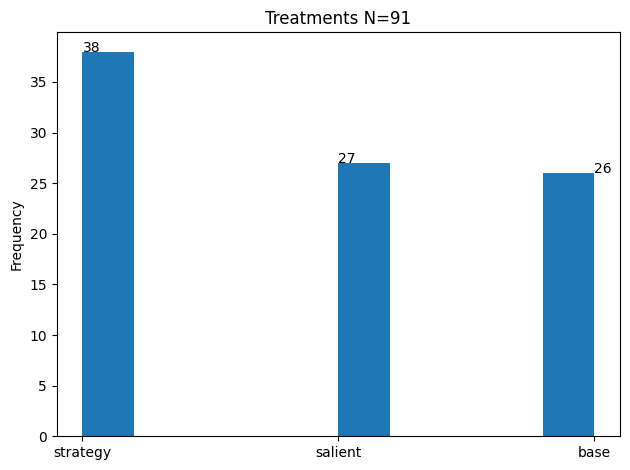

In [22]:
fig, ax = plt.subplots()
y = [i for i in  data['participant.treatment']]
Labels = ['strategy', 'salient', 'base']
ax.hist(y)
plt.ylabel('Frequency')
for j in range(3):
    plt.text(j,y.count(Labels[j]),str(y.count(Labels[j])))
plt.title(f'Treatments N={len(y)}')
plt.tight_layout()
# plt.savefig(outputpath + 'treatments.png',dpi=1000)
plt.show()

## CQs

info_cost_cq_mistakes


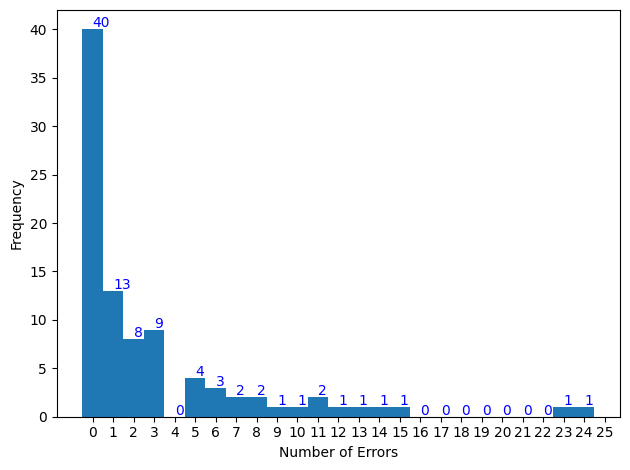

intro_cq_mistakes


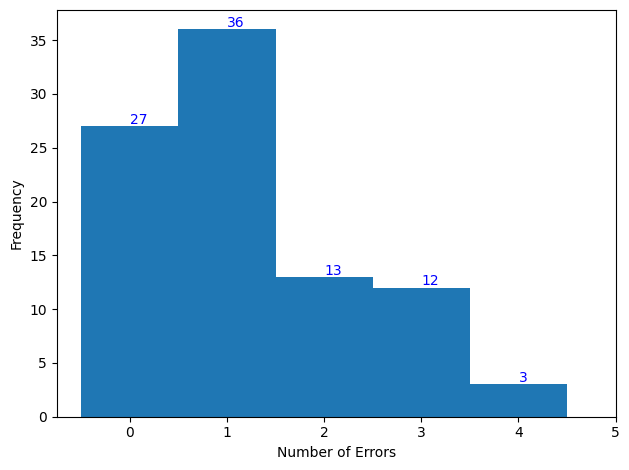

In [23]:
data['info_cost_cq_mistakes'] = data[['informational_cost.1.player.info_cost_cq_mistakes','informational_cost.2.player.info_cost_cq_mistakes','informational_cost.3.player.info_cost_cq_mistakes','informational_cost.4.player.info_cost_cq_mistakes','informational_cost.5.player.info_cost_cq_mistakes','strategy_method.1.player.info_cost_cq_mistakes','strategy_method.2.player.info_cost_cq_mistakes','strategy_method.3.player.info_cost_cq_mistakes','strategy_method.4.player.info_cost_cq_mistakes','strategy_method.5.player.info_cost_cq_mistakes']].sum(axis=1)
# print(data[['info_cost_cq_mistakes', 'strategy_method.1.player.info_cost_cq_mistakes','strategy_method.2.player.info_cost_cq_mistakes','strategy_method.3.player.info_cost_cq_mistakes', 'informational_cost.1.player.info_cost_cq_mistakes','informational_cost.2.player.info_cost_cq_mistakes','informational_cost.3.player.info_cost_cq_mistakes']])
data['intro_cq_mistakes'] = data[['informational_cost.1.player.intro_cq_mistakes', 'strategy_method.1.player.intro_cq_mistakes']].sum(axis=1)
# print(data[['intro_cq_mistakes','informational_cost.1.player.intro_cq_mistakes', 'strategy_method.1.player.intro_cq_mistakes']])

col_list = []
col_list_names = []
for col in data[['info_cost_cq_mistakes','intro_cq_mistakes']]:
    col_list.append(data[col])
    col_list_names.append(col)

for var in col_list:
    try:
        print(var.name)
        fig, ax = plt.subplots()
        y = [int(i) for i in  var]
        xLabels = range(max(y)+2)
        x = np.arange(max(y)+2)
        ax.hist(y,x-0.5, width=1)
        plt.ylabel('Frequency')
        for i in range(max(y)+1):
            plt.text(i,y.count(i)+.2,y.count(i), color='blue')
        plt.xticks(x, xLabels)
        plt.xlabel('Number of Errors')
#         plt.title(f"{var.name[19:-9]}; N={len(var)}")
        plt.tight_layout()
#         plt.savefig(outputpathErrors+ var.name[10:-9] +'.png',dpi=1000)
        plt.show()
    except:
        print('Variable missing:', var.name)

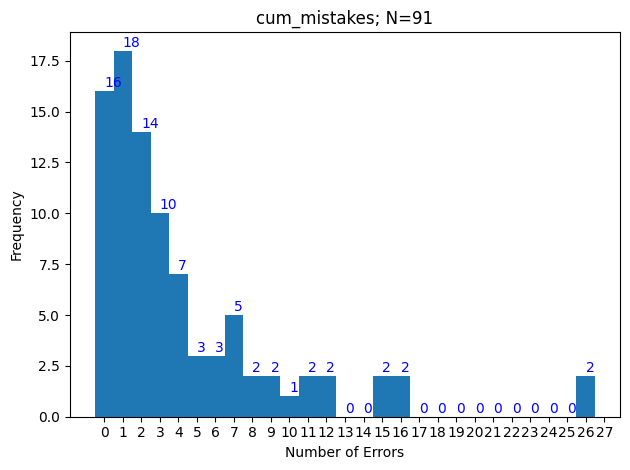

In [24]:
data['cum_mistakes']=data[col_list_names].sum(axis=1)

maximum_mistakes_allowed = 100 
var = data[data['cum_mistakes']<maximum_mistakes_allowed]['cum_mistakes']
fig, ax = plt.subplots()
y = [int(i) for i in  var]
xLabels = range(max(y)+2)
x = np.arange(max(y)+2)
ax.hist(y,x-0.5, width=1)
plt.ylabel('Frequency')
for i in range(max(y)+1):
    plt.text(i,y.count(i)+.2,y.count(i), color='blue')
plt.xticks(x, xLabels)
plt.xlabel('Number of Errors')
plt.title(f"{var.name}; N={len(var)}")
plt.tight_layout()
plt.savefig(outputpathErrors+ var.name +'.png',dpi=1000)
plt.show()

data = data[data['cum_mistakes']<maximum_mistakes_allowed]

### Destring param_rounds 

In [25]:
try:
    for ind in data.index:
        ini_list = data['participant.param_rounds'][ind]
        res = ini_list.strip('][').split(', ')
        data['participant.param_rounds'][ind] = res
    print(data['participant.param_rounds'])
except:
    print('you cannot run this code twice, and you have already run it. Run "cleaning data" again to be able to run this code')

173    [5, 3, 1, 2, 4]
175    [2, 4, 5, 3, 1]
176    [3, 2, 1, 5, 4]
177    [2, 3, 4, 1, 5]
178    [4, 5, 3, 1, 2]
            ...       
307    [1, 2, 5, 4, 3]
308    [3, 2, 1, 4, 5]
309    [2, 1, 3, 5, 4]
310    [2, 3, 4, 1, 5]
311    [2, 1, 3, 5, 4]
Name: participant.param_rounds, Length: 91, dtype: object


### Risk taker indicator

In [26]:
# Create a column for each round, with that round's parameterization (which varies by participant)
for i in range(1,6):
    myList = []
    for ind in data.index:
        myList.append(int(data['participant.param_rounds'][ind][i-1]))
    #     print(myList,  data['participant.param_rounds'][ind])
    data[f'Round{i}Param'] = myList
#     print(data[f'Round{i}Param'].head(), data['participant.param_rounds'].head())

# Did each person choose the risky option in each round, given their idiosyncratic parameterization??
    risk_list = []
    for ind in data.index:
        param = data[f'Round{i}Param'][ind]
        risk_taker = 1 if data[f'lottery.1.player.lottery{param}'][ind] == 1 else 0
        risk_list.append(risk_taker)
    data[f'risk_taker_R{i}'] = risk_list

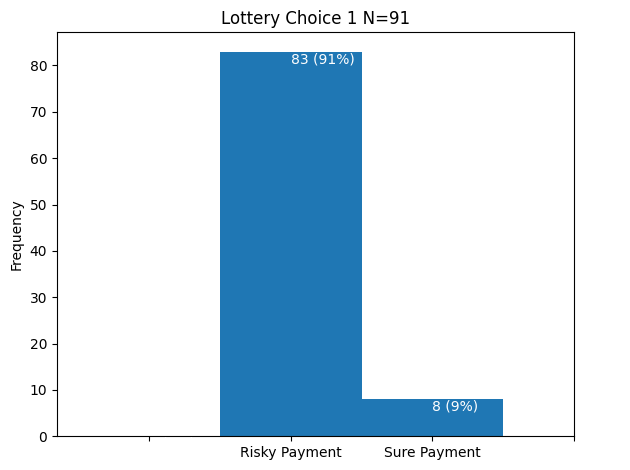

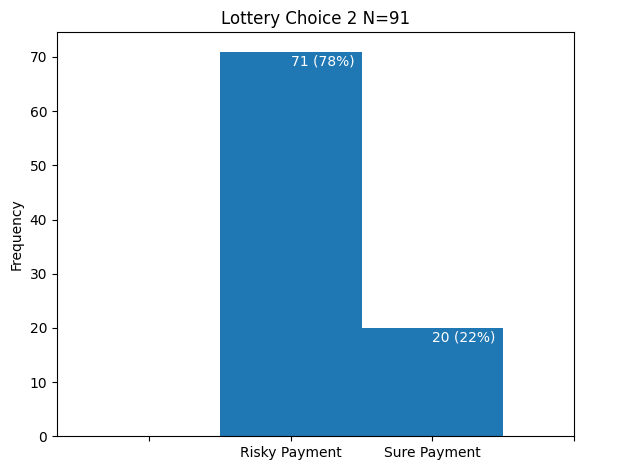

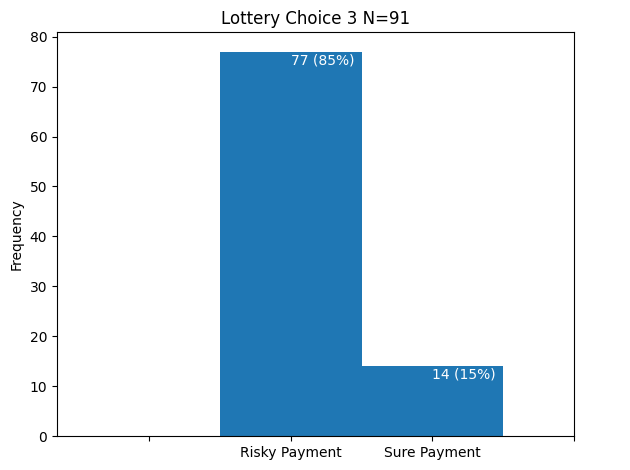

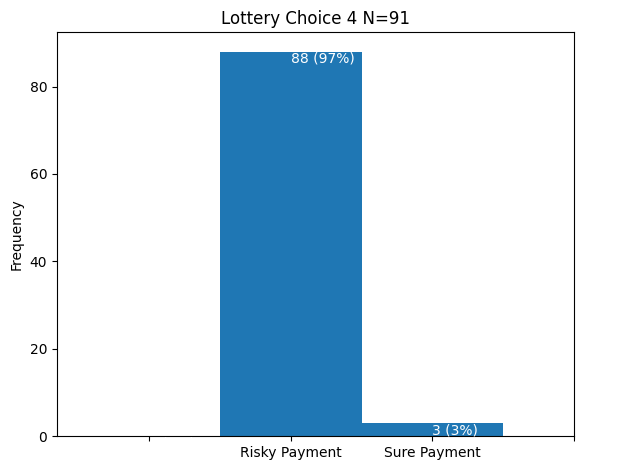

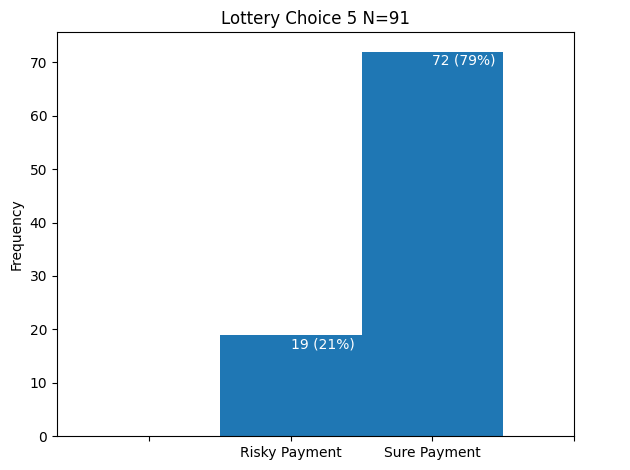

In [27]:
for i in range(1,6):    
    fig, ax = plt.subplots()
#     base_risk = base[base[f'risk_taker_R{i}'] == 1]
    y = [int(i) for i in data[f'lottery.1.player.lottery{i}']]
    xLabels = ['','Risky Payment', 'Sure Payment','']
    x = np.arange(max(y)+2)
    ax.hist(y,x-0.5, width=1)
    plt.ylabel('Frequency')
    for j in range(max(y)+2):
        plt.text(j,y.count(j)-2.5,str(y.count(j))+ ' (' + str(round(y.count(j)*100/len(y))) +'%)', color='white')
    plt.xticks(x, xLabels)
    plt.title(f'Lottery Choice {i} N={len(y)}')
    plt.tight_layout()
#     plt.savefig(outputpath + 'Base_environment1.png',dpi=1000)
    plt.show()

[91.20879120879121, 78.02197802197801, 84.61538461538461, 96.7032967032967, 20.879120879120876]


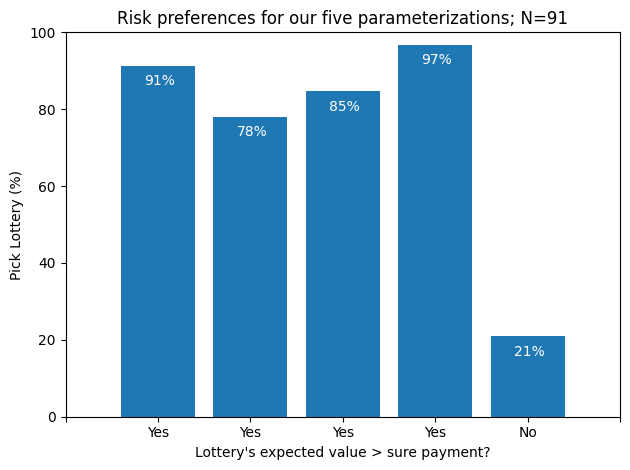

In [28]:
avgs = []
rounds_num = 5
for i in range(1,rounds_num+1):
    # lottery var takes values 1&2, where 1 is lottery and 2 is sure payment. 
    data[f'normalized.lottery{i}'] = data[f'lottery.1.player.lottery{i}'] - 1
    # now lottery var takes values 0&1, where 0 is lottery and 1 is sure payment. 
    avg_environment = 100-(data[f'normalized.lottery{i}'].mean())*100 # this is the share who picks lottery
    avgs.append(avg_environment)
print(avgs)
avgs_avg = sum(avgs[:rounds_num])/len(avgs[:rounds_num])

plt.bar(range(1,rounds_num+1), avgs, label=f'Baseline N={len(data)}')
for j in range(5):
    plt.text(j+0.85,avgs[j]-5,str(round(avgs[j]))+'%', color='white')
plt.xlabel("Lottery's expected value > sure payment?")
plt.ylabel("Pick Lottery (%)")
plt.xlim(1, rounds_num)
plt.xticks(np.arange(0,rounds_num+2), ['','Yes', 'Yes', 'Yes', 'Yes', 'No', ''])  # Set text labels.
plt.ylim(0, 100)
# plt.axvline(x=5.5, linewidth=2, color = 'k')
# plt.axhline(y=avgs_base_avg, xmin=0,xmax=0.5, linewidth=1, color = 'k')
# plt.text(2.5,avgs_base_avg+3,str(round(avgs_base_avg,1))+'%')

# plt.legend(loc='center left')
plt.title(f'Risk preferences for our five parameterizations; N={len(data)}')
plt.tight_layout()
plt.savefig(outputpath + 'risk_preferences.png',dpi=1000)
plt.show()

## Baseline

In [29]:
base = data[data['participant.treatment']== 'base']
print('In Baseline we have', len(base['participant.treatment']), 'participants')
#  How many pooled in round 1 when pooling was optimal?
print(base[base['Round1Param'] == 5]['informational_cost.1.player.environment_choice'])

# How many participants chose risky option in lottery associated with round 1 parameters?
print('Chose risky in first round:', base[base['risk_taker_R1'] == 1]['risk_taker_R1'].count(), '; Chose safe in first round:', base[base['risk_taker_R1'] == 0]['risk_taker_R1'].count())

In Baseline we have 26 participants
248    0.0
255    1.0
274    1.0
286    1.0
303    1.0
305    1.0
Name: informational_cost.1.player.environment_choice, dtype: float64
Chose risky in first round: 18 ; Chose safe in first round: 8


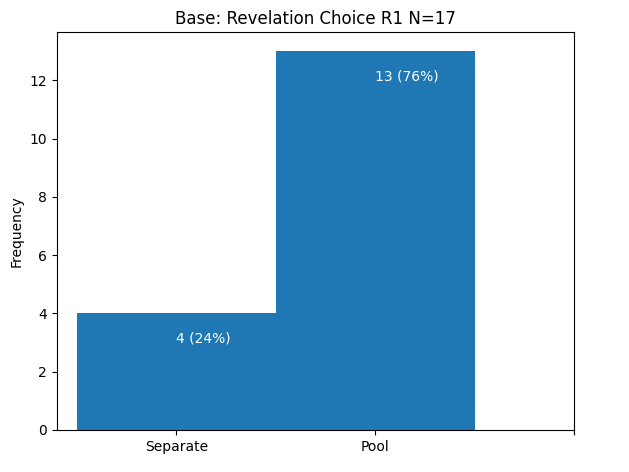

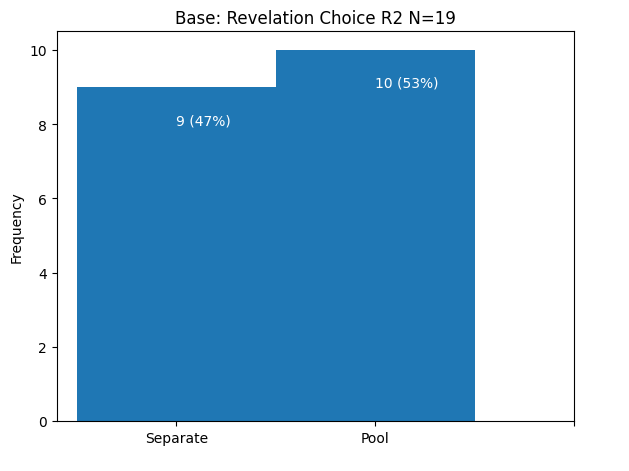

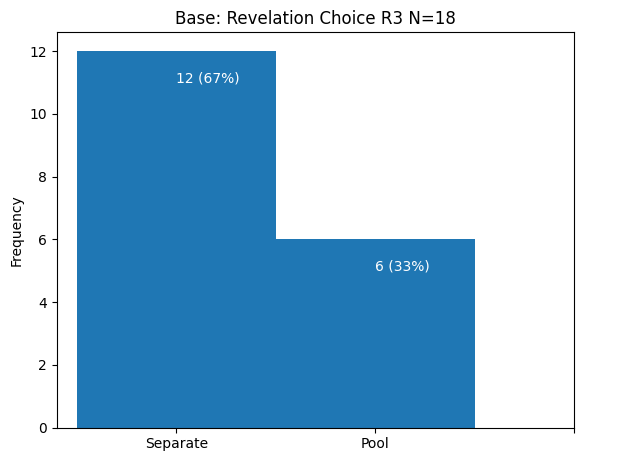

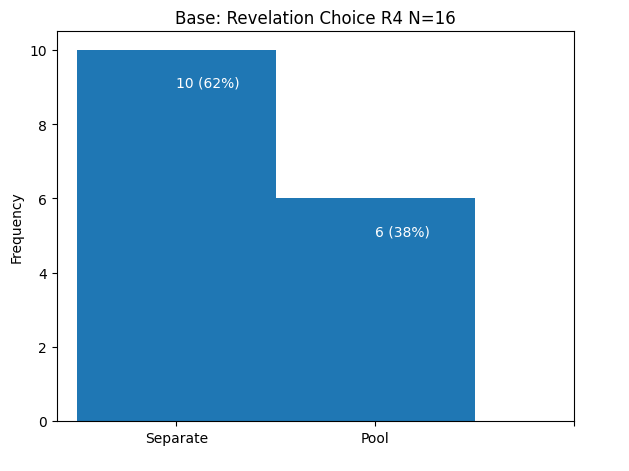

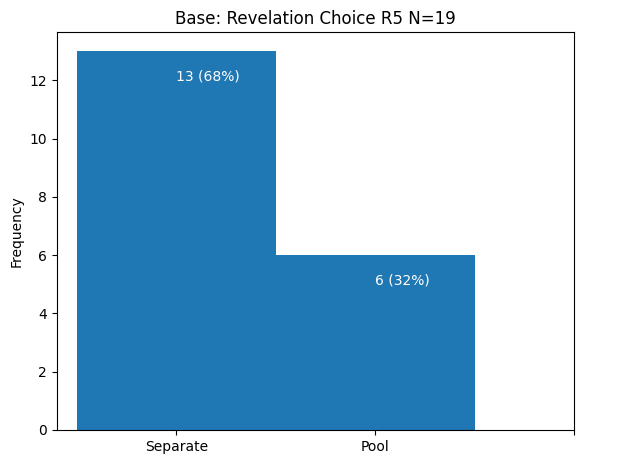

In [30]:
for i in range(1,6): 
    fig, ax = plt.subplots()
    base_risk = base[base[f'risk_taker_R{i}'] == 1]  # plot only for the subsample of risk-takers
    y = [int(i) for i in base_risk[base_risk[f'Round{i}Param'] != 5][f'informational_cost.{i}.player.environment_choice']] # plot only where risk-taking optimal
    xLabels = ['Separate', 'Pool', '']
    x = np.arange(max(y)+2)
    ax.hist(y,x-0.5, width=1)
    plt.ylabel('Frequency')
    for j in range(max(y)+2):
        plt.text(j,y.count(j)-1,str(y.count(j))+ ' (' + str(round(y.count(j)*100/len(y))) +'%)', color='white')
    plt.xticks(x, xLabels)
    plt.title(f'Base: Revelation Choice R{i} N={len(y)}')
    plt.tight_layout()
    plt.savefig(outputpath + f'Base_environment{i}.png',dpi=1000)
    plt.show()

## Salient

In [31]:
salient = data[data['participant.treatment']== 'salient']
print('In Salient we have', len(salient['participant.treatment']), 'participants')
#  How many pooled in round 1 when pooling was optimal?
print(salient[salient['Round1Param'] == 5]['informational_cost.1.player.environment_choice'])

# How many participants chose risky option in lottery associated with round 1 parameters?
print('Chose risky in first round:', salient[salient['risk_taker_R1'] == 1]['risk_taker_R1'].count(), '; Chose safe in first round:', salient[salient['risk_taker_R1'] == 0]['risk_taker_R1'].count())

In Salient we have 27 participants
180    0.0
242    0.0
249    1.0
261    1.0
295    0.0
297    0.0
Name: informational_cost.1.player.environment_choice, dtype: float64
Chose risky in first round: 21 ; Chose safe in first round: 6


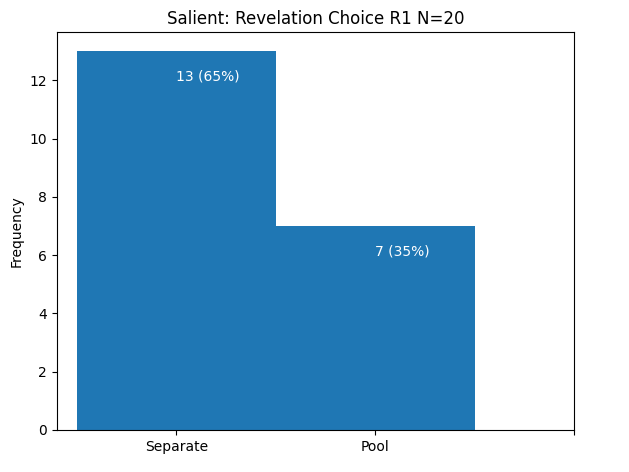

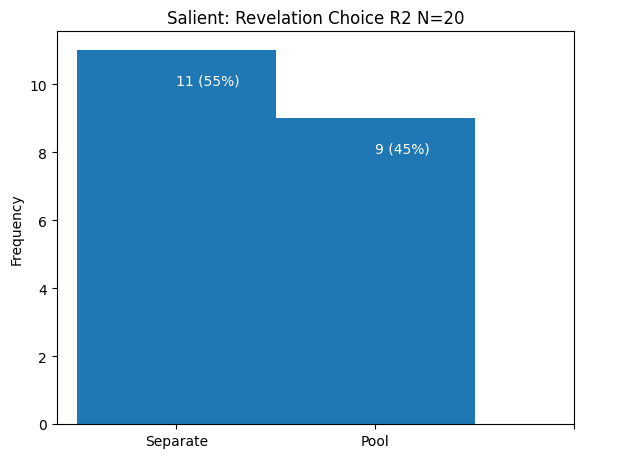

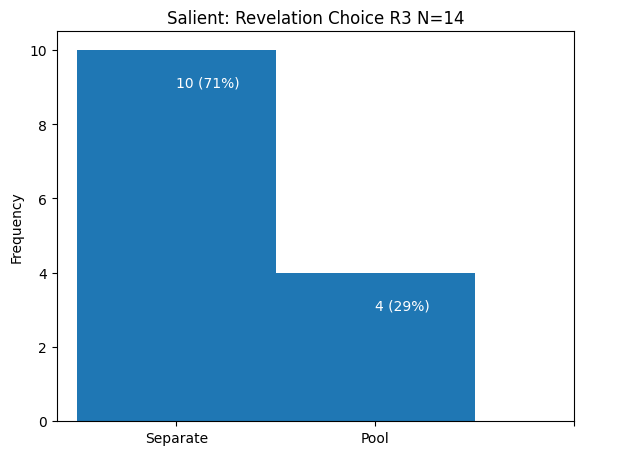

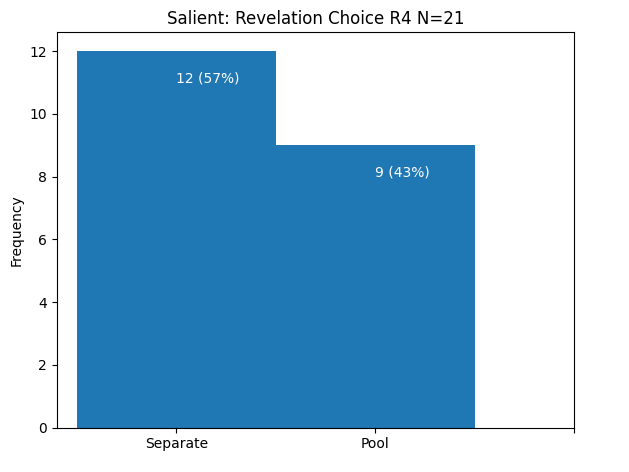

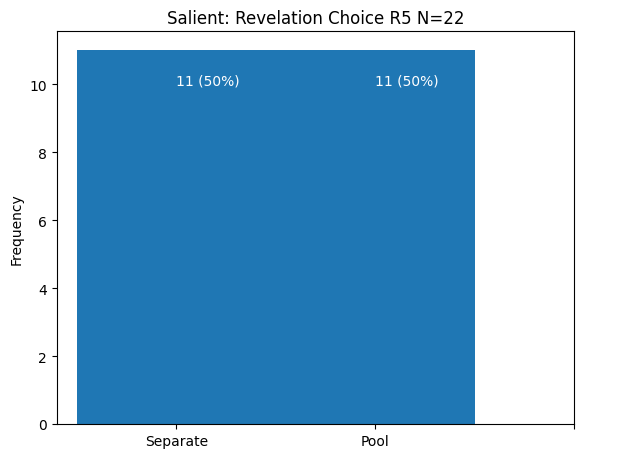

In [32]:
for i in range(1,6):    
    fig, ax = plt.subplots()
    salient_risk = salient[salient[f'risk_taker_R{i}'] == 1] # plot only for the subsample of risk-takers
    y = [int(i) for i in salient_risk[salient_risk[f'Round{i}Param'] != 5][f'informational_cost.{i}.player.environment_choice']] # plot only where risk-taking optimal
#     print(y)
    xLabels = ['Separate', 'Pool', '']
    x = np.arange(max(y)+2)
    ax.hist(y,x-0.5, width=1)
    plt.ylabel('Frequency')
    for j in range(max(y)+2):
        plt.text(j,y.count(j)-1,str(y.count(j))+ ' (' + str(round(y.count(j)*100/len(y))) +'%)', color='white')
    plt.xticks(x, xLabels)
    plt.title(f'Salient: Revelation Choice R{i} N={len(y)}')
    plt.tight_layout()
    plt.savefig(outputpath + f'Salient_environment{i}.png',dpi=1000)
    plt.show()

## Strategy

In [33]:
strategy = data[data['participant.treatment']== 'strategy']
print('In Strategy we have', len(strategy['participant.treatment']), 'participants')
#  How many pooled in round 1 when pooling was optimal?
print(strategy[strategy['Round1Param'] == 5]['strategy_method.1.player.environment_choice'])

# How many participants chose risky option in lottery associated with round 1 parameters?
print('Chose risky in first round:', strategy[strategy['risk_taker_R1'] == 1]['risk_taker_R1'].count(), '; Chose safe in first round:', strategy[strategy['risk_taker_R1'] == 0]['risk_taker_R1'].count())

In Strategy we have 38 participants
173    0.0
185    1.0
235    1.0
240    1.0
250    1.0
264    0.0
271    0.0
278    0.0
282    0.0
Name: strategy_method.1.player.environment_choice, dtype: float64
Chose risky in first round: 27 ; Chose safe in first round: 11


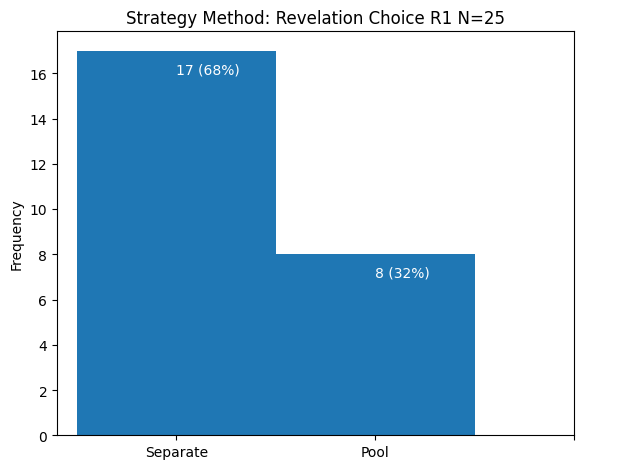

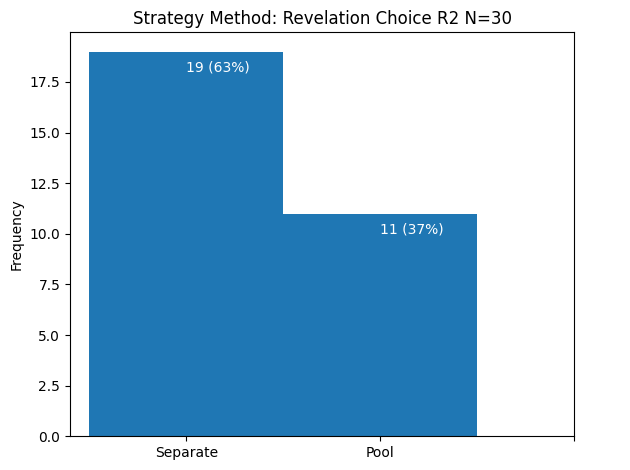

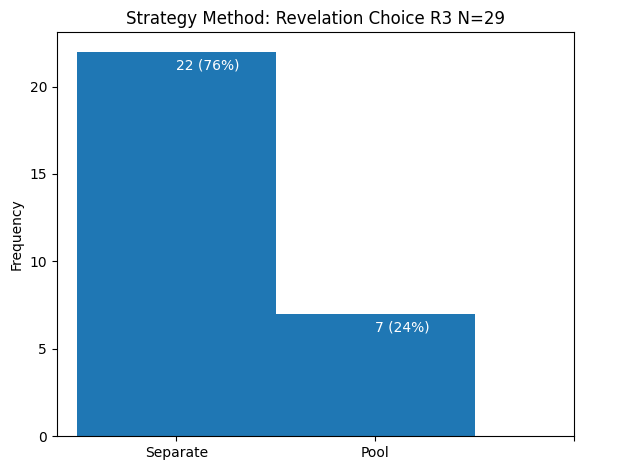

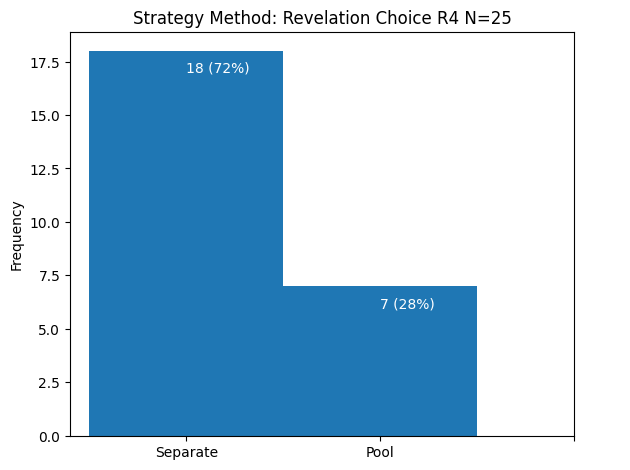

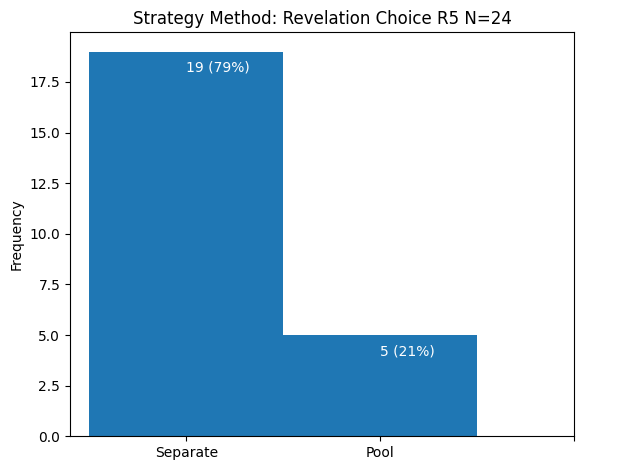

In [34]:
for i in range(1,6):    
    fig, ax = plt.subplots()
    strategy_risk = strategy[strategy[f'risk_taker_R{i}'] == 1] # plot only for the subsample of risk-takers
    y = [int(i) for i in strategy_risk[strategy_risk[f'Round{i}Param'] != 5][f'strategy_method.{i}.player.environment_choice']] # plot only where risk-taking optimal
#     print(y)
    xLabels = ['Separate', 'Pool', '']
    x = np.arange(max(y)+2)
    ax.hist(y,x-0.5, width=1)
    plt.ylabel('Frequency')
    for j in range(max(y)+2):
        plt.text(j,y.count(j)-1,str(y.count(j))+ ' (' + str(round(y.count(j)*100/len(y))) +'%)', color='white')
    plt.xticks(x, xLabels)
    plt.title(f'Strategy Method: Revelation Choice R{i} N={len(y)}')
    plt.tight_layout()
    plt.savefig(outputpath + f'Strategy_environment{i}.png',dpi=1000)
    plt.show()

## Revelation by decision

Base: [76.47058823529412, 52.63157894736842, 33.33333333333333, 37.5, 31.57894736842105] Salient: [35.0, 45.0, 28.57142857142857, 42.857142857142854, 50.0] Strategy: [32.0]


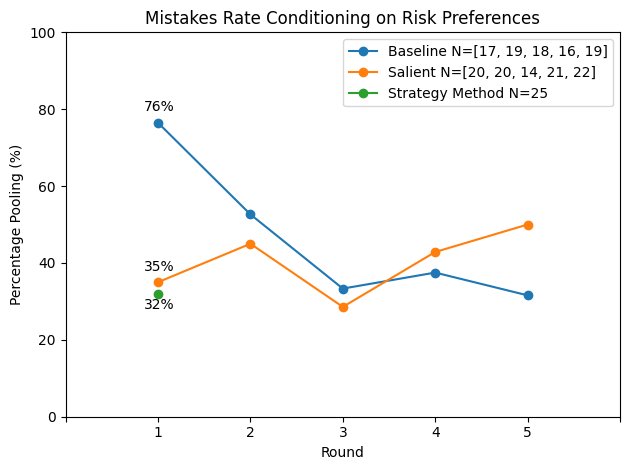

In [35]:
avgs_base = []
avgs_salient= []
avgs_strategy = []
rounds_num = 5
lengths_base=[]
lengths_salient=[]
lengths_strategy=[]

# for i in range(1,2):
for i in range(1,rounds_num+1):
#   BASELINE
    base_risk = base[base[f'risk_taker_R{i}'] == 1] # this picks people who picked risky option in that round's lottery
    base_risk = base_risk[base_risk[f'Round{i}Param'] != 5] # this kicks out those for whom pooling was optimal
    avg_environment = base_risk[f'informational_cost.{i}.player.environment_choice'].mean()*100
    avgs_base.append(avg_environment)
    lengths_base.append(len(base_risk))
    
# for i in range(1,2):
#     SALIENT
    salient_risk = salient[salient[f'risk_taker_R{i}'] == 1] # this picks people who picked risky option in that round's lottery
    salient_risk = salient_risk[salient_risk[f'Round{i}Param'] != 5] # this kicks out those for whom pooling was optimal
    avg_environment = salient_risk[f'informational_cost.{i}.player.environment_choice'].mean()*100
    avgs_salient.append(avg_environment)
    lengths_salient.append(len(salient_risk))
    
for i in range(1,2):    
#     STRATEGY        
    strategy_risk = strategy[strategy[f'risk_taker_R{i}'] == 1] # this picks people who picked risky option in that round's lottery
    strategy_risk = strategy_risk[strategy_risk[f'Round{i}Param'] != 5] # this kicks out those for whom pooling was optimal
    avg_environment = strategy_risk[f'strategy_method.{i}.player.environment_choice'].mean()*100
    avgs_strategy.append(avg_environment)
    lengths_strategy.append(len(strategy_risk))

# print('Chose risky in first round:', strategy[strategy['risk_taker_R1'] == 1]['risk_taker_R1'].count())
print('Base:', avgs_base, 'Salient:',avgs_salient, 'Strategy:', avgs_strategy)
# avgs_base_avg = sum(avgs_base[:rounds_num])/len(avgs_base[:rounds_num])
# avgs_sal_avg = sum(avgs_salient[:rounds_num])/len(avgs_salient[:rounds_num])
# avgs_strategy_avg = sum(avgs_strategy[:rounds_num])/len(avgs_strategy[:rounds_num])

plt.plot(range(1,rounds_num+1), avgs_base, label=f'Baseline N={lengths_base}', marker="o")
# plt.plot(range(1,2), avgs_base, label=f'Baseline N={lengths_base[0]}', marker="o")

# plt.plot(range(1,2), avgs_salient, label=f'Salient N={lengths_salient[0]}', marker="o")
plt.plot(range(1,rounds_num+1), avgs_salient, label=f'Salient N={lengths_salient}', marker="o")

# plt.plot(range(1,rounds_num+1), avgs_strategy, label=f'Strategy Method N={lengths_strategy}', marker="o")
plt.plot(range(1,2), avgs_strategy, label=f'Strategy Method N={lengths_strategy[0]}', marker="o")

plt.xlabel("Round")
plt.ylabel("Percentage Pooling (%)")
plt.xlim(0, rounds_num+1)
plt.xticks(np.arange(0,rounds_num+2), ['', '1', '2', '3', '4', '5', ''])  # Set text labels.
plt.ylim(0, 100)
# plt.axvline(x=5.5, linewidth=2, color = 'k')
# plt.axhline(y=avgs_base_avg, xmin=0,xmax=0.5, linewidth=1, color = 'k')
# plt.text(2.5,avgs_base_avg+3,str(round(avgs_base_avg,1))+'%')
plt.text(0.85,avgs_base[0]+3,str(round(avgs_base[0]))+'%')
plt.text(0.85,avgs_salient[0]+3,str(round(avgs_salient[0]))+'%')
plt.text(0.85,avgs_strategy[0]-4,str(round(avgs_strategy[0]))+'%')

# plt.axhline(y=avgs_sal_avg, xmin=0,xmax=0.5, linewidth=1, color = 'k')
# plt.text(2.5,avgs_sal_avg-4,str(round(avgs_sal_avg,1))+'%')

plt.legend()
plt.title(f'Mistakes Rate Conditioning on Risk Preferences')
plt.tight_layout()
# plt.savefig(outputpath + 'environment_by_round_baseline_R1.png',dpi=1000)
# plt.savefig(outputpath + 'environment_by_round_baseline.png',dpi=1000)
# plt.savefig(outputpath + 'environment_by_round_salient_R1.png',dpi=1000)
# plt.savefig(outputpath + 'environment_by_round_salient.png',dpi=1000)
plt.savefig(outputpath + 'environment_by_round_strategy_R1.png',dpi=1000)
# plt.savefig(outputpath + 'environment_by_round_strategy.png',dpi=1000)
plt.show()

### Let's look at those who see parameterization 5, do they make mistakes?

In [36]:
for i in range(1,rounds_num+1):
    print(base[base[f'Round{i}Param'] == 5][[f'risk_taker_R{i}', f'informational_cost.{i}.player.environment_choice']])
#     print(base[[f'Round{i}Param', f'risk_taker_R{i}']])

     risk_taker_R1  informational_cost.1.player.environment_choice
248              0                                             0.0
255              0                                             1.0
274              0                                             1.0
286              0                                             1.0
303              1                                             1.0
305              0                                             1.0
     risk_taker_R2  informational_cost.2.player.environment_choice
182              0                                             1.0
232              1                                             0.0
292              0                                             0.0
299              0                                             0.0
     risk_taker_R3  informational_cost.3.player.environment_choice
239              1                                             0.0
252              0                                            

### How much do people pool when its optimal to pool? - in Base

In [37]:
avgs_base = []
for i in range(1,6):
#     BASELINE
    base_risk = base[base[f'risk_taker_R{i}'] == 0] # this picks people who picked safe option in that round's lottery (for whom pooling here is optimal)
    base_risk = base_risk[(base_risk[f'Round{i}Param'] == 5)] # this picks those for whom pooling was optimal
    avg_environment = base_risk[f'informational_cost.{i}.player.environment_choice'].mean()
    avgs_base.append(avg_environment)
    print(len(base_risk))
print(avgs_base)
print(sum(avgs_base)/len(avgs_base))

avgs_salient = []
for i in range(1,6):
#     SALIENT
    salient_risk = salient[salient[f'risk_taker_R{i}'] == 0] # this picks people who picked safe option in that round's lottery (for whom pooling here is optimal)
    salient_risk = salient_risk[(salient_risk[f'Round{i}Param'] == 5)] # this picks those for whom pooling was optimal
    avg_environment = salient_risk[f'informational_cost.{i}.player.environment_choice'].mean()
    avgs_salient.append(avg_environment)
    print(len(salient_risk))
print(avgs_salient)
print(sum(avgs_salient)/len(avgs_salient))

avgs_strategy = []
for i in range(1,6):
#     SALIENT
    strategy_risk = strategy[strategy[f'risk_taker_R{i}'] == 0] # this picks people who picked safe option in that round's lottery (for whom pooling here is optimal)
    strategy_risk = strategy_risk[(strategy_risk[f'Round{i}Param'] == 5)] # this picks those for whom pooling was optimal
    avg_environment = strategy_risk[f'strategy_method.{i}.player.environment_choice'].mean()
    avgs_strategy.append(avg_environment)
    print(len(strategy_risk))
print(avgs_strategy)
print(sum(avgs_strategy)/len(avgs_strategy))

5
3
3
6
4
[0.8, 0.3333333333333333, 1.0, 0.3333333333333333, 0.0]
0.49333333333333335
5
2
6
3
4
[0.4, 1.0, 0.6666666666666666, 0.0, 0.25]
0.46333333333333326
7
4
4
8
8
[0.5714285714285714, 0.5, 0.5, 0.375, 0.5]
0.4892857142857142


### Do people who (always) separate when its optimal to separate, also pool when its optimal to pool? - in Base

In [38]:
for i in range(1,6):
    base[f'optimal{i}'] = np.nan
    for ind in base.index:
        base[f'optimal{i}'][ind] = 1 if (base[f'risk_taker_R{i}'][ind]==1 and base[f'informational_cost.{i}.player.environment_choice'][ind]==0) else 0
        base[f'optimal{i}'][ind] = 1 if (base[f'risk_taker_R{i}'][ind]==0 and base[f'informational_cost.{i}.player.environment_choice'][ind]==1) else base[f'optimal{i}'][ind]
    print(base[[f'optimal{i}',f'risk_taker_R{i}',f'informational_cost.{i}.player.environment_choice']])
#         if base[f'optimal{i}'][ind]:
#             base[f'optimal{i}'] = 0  


     optimal1  risk_taker_R1  informational_cost.1.player.environment_choice
179       1.0              0                                             1.0
181       0.0              1                                             1.0
182       0.0              1                                             1.0
232       0.0              1                                             1.0
237       0.0              1                                             1.0
239       0.0              1                                             1.0
243       1.0              1                                             0.0
247       0.0              1                                             1.0
248       0.0              0                                             0.0
252       0.0              1                                             1.0
253       0.0              1                                             1.0
255       1.0              0                                             1.0

     optimal5  risk_taker_R5  informational_cost.5.player.environment_choice
179       0.0              1                                             1.0
181       1.0              1                                             0.0
182       0.0              1                                             1.0
232       1.0              1                                             0.0
237       1.0              1                                             0.0
239       1.0              1                                             0.0
243       1.0              1                                             0.0
247       0.0              0                                             0.0
248       0.0              0                                             0.0
252       0.0              1                                             1.0
253       0.0              0                                             0.0
255       0.0              1                                             1.0

In [39]:
#  pooling_round1 and pooling_round2 pick the rounds in which pooling is optimal for each subject
base['pooling_round1'] = np.nan
for i in range(1,6):
    for ind in base.index:
        if base[f'Round{i}Param'][ind] == 5:
            base['pooling_round1'][ind] = i

base['always_optimally_separated'] = np.nan
for ind in base.index:
    counter = 0
    a = base['pooling_round1'][ind]
    rounds = [1,2,3,4,5]
    rounds.remove(a)
    for i in rounds:
        if base[f'optimal{i}'][ind]==1 and base[f'risk_taker_R{i}'][ind]==1:
            counter +=1
    base['always_optimally_separated'][ind]=1 if counter == 4 else 0

base_optimally_separated = base[base['always_optimally_separated'] == 1] # this picks people who chose optimally 
pooling_base = []
for ind in base_optimally_separated.index:
    a = int(base_optimally_separated['pooling_round1'][ind])
    choice_in_pooling = base_optimally_separated[f'informational_cost.{a}.player.environment_choice'][ind]
    pooling_base.append(choice_in_pooling)
print(len(base_optimally_separated),len(pooling_base),pooling_base)
print('Fraction of the 20 decisions in which they pool when its optimal, for people who always do optimal:', sum(pooling_base)/len(pooling_base))

4 4 [1.0, 0.0, 0.0, 1.0]
Fraction of the 20 decisions in which they pool when its optimal, for people who always do optimal: 0.5


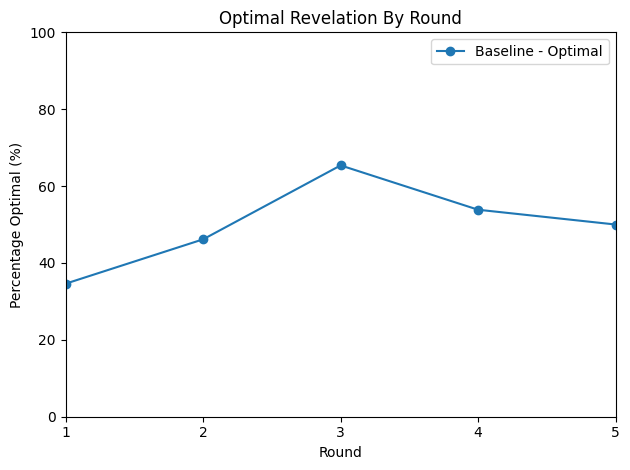

In [40]:
avgs_base = []
for i in range(1,6):
#     BASELINE
    avg_environment = base[f'optimal{i}'].mean()*100
    avgs_base.append(avg_environment)

plt.plot(range(1,6), avgs_base, label='Baseline - Optimal', marker="o")

plt.xlabel("Round")
plt.ylabel("Percentage Optimal (%)")
plt.xlim(1, 5)
plt.xticks(np.arange(1,6), range(1,6))  # Set text labels.
plt.ylim(0, 100)
plt.axvline(x=5.5, linewidth=2, color = 'k')
plt.legend()
plt.title('Optimal Revelation By Round')
plt.tight_layout()
# plt.savefig(outputpath + 'environment_by_round.png',dpi=1000)
plt.show()

## Let's look at parameterization to check whether we learn anything from that

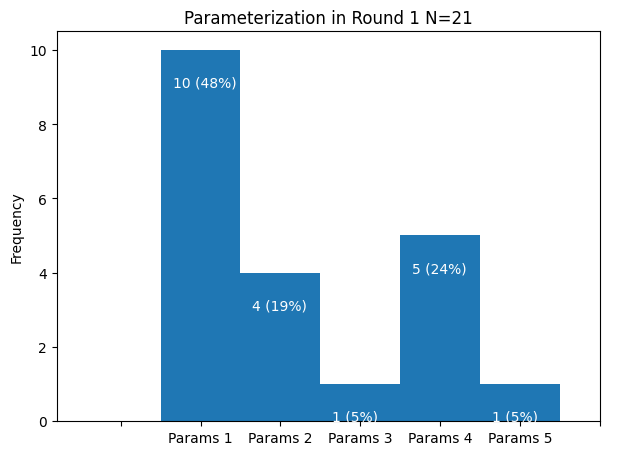

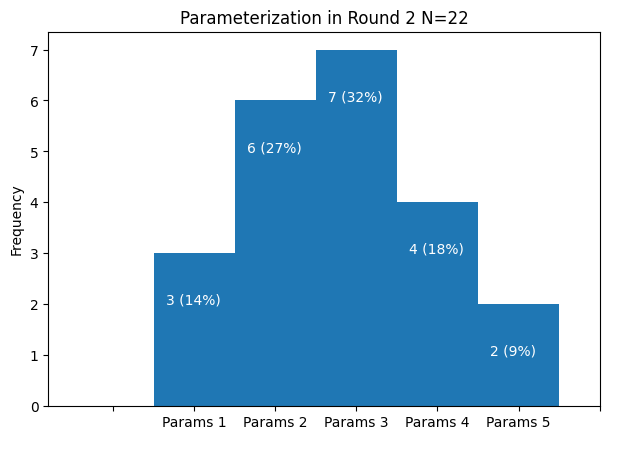

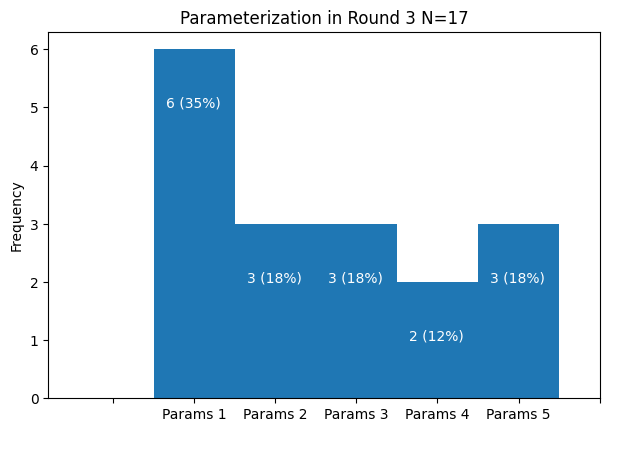

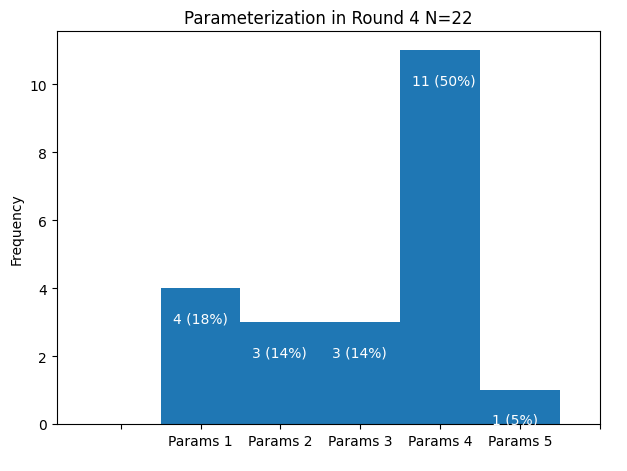

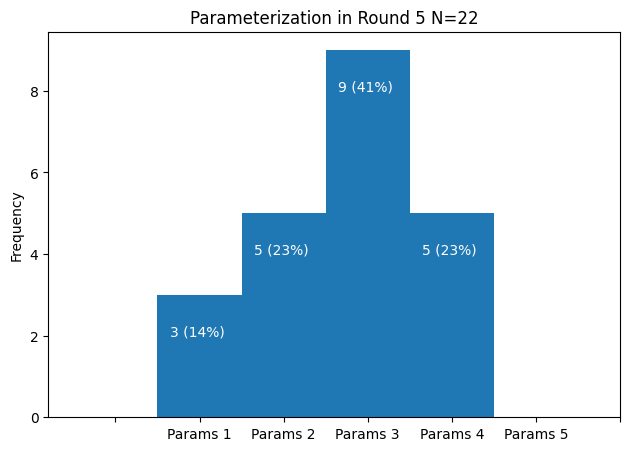

In [41]:
for i in range(1,6):    
    fig, ax = plt.subplots()
    data_risk = salient[salient[f'risk_taker_R{i}'] == 1] # plot only for the subsample of risk-takers
#     data_risk = data
    y = [int(i) for i in data_risk[f'Round{i}Param']] # plot only where risk-taking optimal
#     print(y)
    xLabels = ['', 'Params 1', 'Params 2', 'Params 3', 'Params 4', 'Params 5', '']
    x = np.arange(7)
    ax.hist(y,x-0.5, width=1)
    plt.ylabel('Frequency')
    for j in range(max(y)+2):
        plt.text(j-0.35,y.count(j)-1,str(y.count(j))+ ' (' + str(round(y.count(j)*100/len(y))) +'%)', color='white')
    plt.xticks(x, xLabels)
    plt.title(f'Parameterization in Round {i} N={len(y)}')
    plt.tight_layout()
#     plt.savefig(outputpath + f'Strategy_environment{i}.png',dpi=1000)
    plt.show()

## Bonus Choice

#### Destring compTypes, chosen_decisions, and environment_choice

In [42]:
try:
    for ind in data.index:
        ini_list = data['participant.compType'][ind]
        res = ini_list.strip('][').split(' ')
        data['participant.compType'][ind] = res
    print(data['participant.compType'])
except:
    print('you cannot run this code twice, and you have already run it. Run "cleaning data" again to be able to run this code')
# try:
#     for ind in data.index:
#         ini_list = data['participant.chosen_decisions'][ind]
#         res = ini_list.strip(')(').split(', ')
#         data['participant.chosen_decisions'][ind] = res
#     print(data['participant.chosen_decisions'])
# except:
#     print('you cannot run this code twice, and you have already run it. Run "cleaning data" again to be able to run this code')

173    [1, 0, 1, 1, 1]
175    [0, 0, 0, 0, 0]
176    [1, 1, 0, 0, 1]
177    [1, 1, 1, 1, 0]
178    [1, 1, 1, 1, 1]
            ...       
307    [0, 1, 1, 0, 0]
308    [1, 1, 1, 0, 0]
309    [1, 1, 0, 1, 0]
310    [0, 0, 1, 1, 1]
311    [1, 0, 0, 1, 0]
Name: participant.compType, Length: 91, dtype: object


##### Create 5 columns, each with compType for each round

In [43]:
for i in range(1,6):
    myList = []
    for ind in data.index:
        myList.append(int(data[f'participant.compType'][ind][i-1]))
    data[f'comp_type_R{i}'] = myList
base = data[data['participant.treatment']== 'base']
salient = data[data['participant.treatment']== 'salient']
strategy = data[data['participant.treatment']== 'strategy']

### Part 2: Bonus Choice - Do people know what to do with the information?


#### Baseline

In [44]:
for i in range(1,6):
    myList = []
    for ind in base.index:
        myList.append(int(base[f'informational_cost.{i}.player.environment_choice'][ind]))
    base[f'EnvChoice_R{i}'] = myList

N= 19
N= 12
N= 11
N= 9
N= 6
[57.89473684210527, 33.33333333333333, 36.36363636363637, 44.44444444444444, 33.33333333333333]


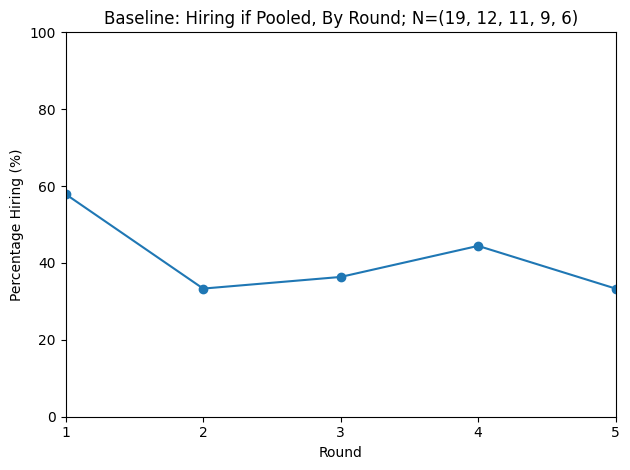

In [45]:
avgs_pool = []
for i in range(1,6):
    base_pool = base[base[f'EnvChoice_R{i}']==1]
    bonus_choice = base_pool[f'informational_cost.{i}.player.bonusChoice'].replace(3, 0)
    avg_pooling = bonus_choice.mean()*100
    avgs_pool.append(avg_pooling)
#     print(base_pool[f'informational_cost.{i}.player.bonusChoice'], bonus_choice)
    print('N=', len(bonus_choice))
print(avgs_pool)
plt.plot(range(1,6), avgs_pool, label='Baseline - Hiring choice for those who pool', marker="o")

plt.xlabel("Round")
plt.ylabel("Percentage Hiring (%)")
plt.xlim(1, 5)
plt.xticks(np.arange(1,6), range(1,6))  # Set text labels.
plt.ylim(0, 100)
plt.axvline(x=5.5, linewidth=2, color = 'k')
# plt.legend()
plt.title('Baseline: Hiring if Pooled, By Round; N=(19, 12, 11, 9, 6)')
plt.tight_layout()
# plt.savefig(outputpath + 'environment_by_round.png',dpi=1000)
plt.show()

N= 19
N= 12
N= 11
N= 9
N= 6
[57.89473684210527, 33.33333333333333, 36.36363636363637, 44.44444444444444, 33.33333333333333]
N= 3
N= 5
N= 8
N= 8
N= 11
[33.33333333333333, 20.0, 25.0, 25.0, 9.090909090909092]
N= 4
N= 9
N= 7
N= 9
N= 9
[50.0, 77.77777777777779, 100.0, 77.77777777777779, 77.77777777777779]


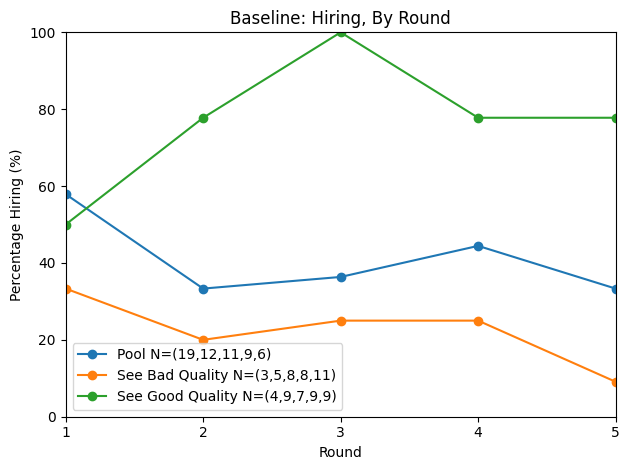

In [46]:
#  POOL
avgs_pool = []
for i in range(1,6):
    base_pool = base[base[f'EnvChoice_R{i}']==1]
    bonus_choice = base_pool[f'informational_cost.{i}.player.bonusChoice'].replace(3, 0)
    avg_pooling = bonus_choice.mean()*100
    avgs_pool.append(avg_pooling)
#     print(base_pool[f'informational_cost.{i}.player.bonusChoice'], bonus_choice)
    print('N=', len(bonus_choice))
print(avgs_pool)
plt.plot(range(1,6), avgs_pool, label='Pool N=(19,12,11,9,6)', marker="o")

#  SEPARATE BAD
avgs_sep = []
for i in range(1,6):
    base_sep = base[base[f'EnvChoice_R{i}']==0]
    bonus_choice = base_sep[base_sep[f'comp_type_R{i}']==0][f'informational_cost.{i}.player.bonusChoice'].replace(3, 0)
    avg_separating = bonus_choice.mean()*100
    avgs_sep.append(avg_separating)
    print('N=', len(bonus_choice))
print(avgs_sep)
plt.plot(range(1,6), avgs_sep, label='See Bad Quality N=(3,5,8,8,11)', marker="o")

#  SEPARATE GOOD
avgs_sep = []
for i in range(1,6):
    base_sep = base[base[f'EnvChoice_R{i}']==0]
    bonus_choice = base_sep[base_sep[f'comp_type_R{i}']==1][f'informational_cost.{i}.player.bonusChoice'].replace(3, 0)
    avg_separating = bonus_choice.mean()*100
    avgs_sep.append(avg_separating)
    print('N=', len(bonus_choice))
print(avgs_sep)
plt.plot(range(1,6), avgs_sep, label='See Good Quality N=(4,9,7,9,9)', marker="o")

plt.xlabel("Round")
plt.ylabel("Percentage Hiring (%)")
plt.xlim(1, 5)
plt.xticks(np.arange(1,6), range(1,6))  # Set text labels.
plt.ylim(0, 100)
plt.axvline(x=5.5, linewidth=2, color = 'k')
plt.legend()
plt.title(f'Baseline: Hiring, By Round')
plt.tight_layout()
plt.savefig(outputpath + 'baseline_bonus_choice_by_round.png',dpi=1000)
plt.show()

### Salient

In [47]:
for i in range(1,6):
    myList = []
    for ind in salient.index:
        myList.append(int(salient[f'informational_cost.{i}.player.environment_choice'][ind]))
    salient[f'EnvChoice_R{i}'] = myList

[55.55555555555556, 38.46153846153847, 27.27272727272727, 63.63636363636363, 41.66666666666667]
[14.285714285714285, 0.0, 0.0, 0.0, 0.0]
[75.0, 85.71428571428571, 87.5, 88.88888888888889, 88.88888888888889]


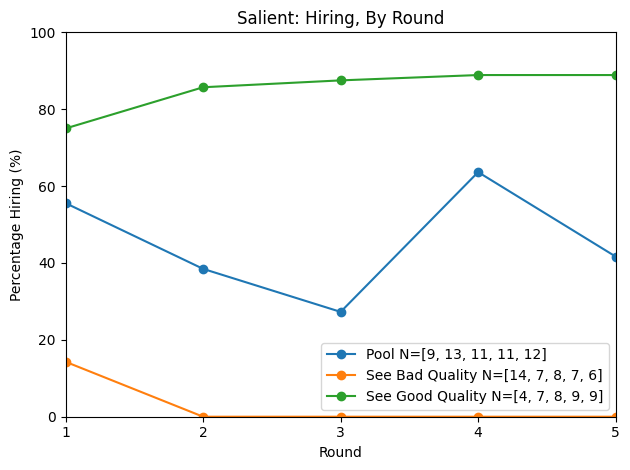

In [48]:
#  POOL
avgs_pool = []
lengths = []
for i in range(1,6):
    salient_pool = salient[salient[f'EnvChoice_R{i}']==1]
    bonus_choice = salient_pool[f'informational_cost.{i}.player.bonusChoice'].replace(3, 0)
    avg_pooling = bonus_choice.mean()*100
    avgs_pool.append(avg_pooling)
#     print(base_pool[f'informational_cost.{i}.player.bonusChoice'], bonus_choice)
    lengths.append(len(bonus_choice))
print(avgs_pool)
plt.plot(range(1,6), avgs_pool, label=f'Pool N={lengths}', marker="o")

#  SEPARATE BAD
lengths = []
avgs_sep = []
for i in range(1,6):
    salient_sep = salient[salient[f'EnvChoice_R{i}']==0]
    bonus_choice = salient_sep[salient_sep[f'comp_type_R{i}']==0][f'informational_cost.{i}.player.bonusChoice'].replace(3, 0)
    avg_separating = bonus_choice.mean()*100
    avgs_sep.append(avg_separating)
    lengths.append(len(bonus_choice))
print(avgs_sep)
plt.plot(range(1,6), avgs_sep, label=f'See Bad Quality N={lengths}', marker="o")

#  SEPARATE GOOD
lengths = []
avgs_sep = []
for i in range(1,6):
    salient_sep = salient[salient[f'EnvChoice_R{i}']==0]
    bonus_choice = salient_sep[salient_sep[f'comp_type_R{i}']==1][f'informational_cost.{i}.player.bonusChoice'].replace(3, 0)
    avg_separating = bonus_choice.mean()*100
    avgs_sep.append(avg_separating)
    lengths.append(len(bonus_choice))
print(avgs_sep)
plt.plot(range(1,6), avgs_sep, label=f'See Good Quality N={lengths}', marker="o")

plt.xlabel("Round")
plt.ylabel("Percentage Hiring (%)")
plt.xlim(1, 5)
plt.xticks(np.arange(1,6), range(1,6))  # Set text labels.
plt.ylim(0, 100)
plt.axvline(x=5.5, linewidth=2, color = 'k')
plt.legend()
plt.title(f'Salient: Hiring, By Round')
plt.tight_layout()
plt.savefig(outputpath + 'salient_bonus_choice_by_round.png',dpi=1000)
plt.show()

### Strategy Method

[47.368421052631575, 39.473684210526315, 36.84210526315789, 36.84210526315789, 34.21052631578947]
[15.789473684210526, 10.526315789473683, 7.894736842105263, 15.789473684210526, 15.789473684210526]
[84.21052631578947, 63.1578947368421, 81.57894736842105, 71.05263157894737, 86.8421052631579]


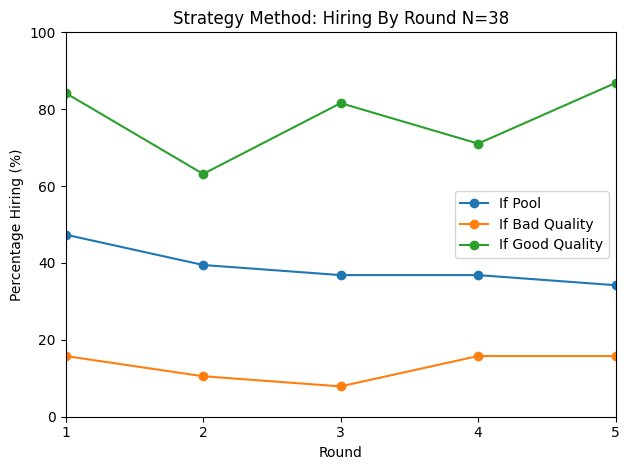

In [49]:
#  POOL
avgs_pool = []
for i in range(1,6):
    bonus_choice = strategy[f'strategy_method.{i}.player.bonusChoicePool'].replace(3, 0)
    avg_pooling = bonus_choice.mean()*100
    avgs_pool.append(avg_pooling)
#     print(base_pool[f'informational_cost.{i}.player.bonusChoice'], bonus_choice)
lengths = len(bonus_choice)
print(avgs_pool)
plt.plot(range(1,6), avgs_pool, label='If Pool', marker="o")

#  SEPARATE BAD
avgs_sep = []
for i in range(1,6):
    bonus_choice = strategy[f'strategy_method.{i}.player.bonusChoiceSepBad'].replace(3, 0)
    avg_separating = bonus_choice.mean()*100
    avgs_sep.append(avg_separating)
lengths = len(bonus_choice)
print(avgs_sep)
plt.plot(range(1,6), avgs_sep, label='If Bad Quality', marker="o")

#  SEPARATE GOOD
avgs_sep = []
for i in range(1,6):
    bonus_choice = strategy[f'strategy_method.{i}.player.bonusChoiceSepGood'].replace(3, 0)
    avg_separating = bonus_choice.mean()*100
    avgs_sep.append(avg_separating)
lengths = len(bonus_choice)
print(avgs_sep)
plt.plot(range(1,6), avgs_sep, label='If Good Quality', marker="o")

plt.xlabel("Round")
plt.ylabel("Percentage Hiring (%)")
plt.xlim(1, 5)
plt.xticks(np.arange(1,6), range(1,6))  # Set text labels.
plt.ylim(0, 100)
plt.axvline(x=5.5, linewidth=2, color = 'k')
plt.legend()
plt.title(f'Strategy Method: Hiring By Round N={lengths}')
plt.tight_layout()
plt.savefig(outputpath + 'strategy_bonus_choice_by_round.png',dpi=1000)
plt.show()

#### Let's condition on what they do in part 1

##### First, condition on what they'll actually will end up doing

In [50]:
for i in range(1,6):
    myList = []
    for ind in strategy.index:
        myList.append(int(strategy[f'strategy_method.{i}.player.environment_choice'][ind]))
    strategy[f'EnvChoice_R{i}'] = myList

[50.0, 31.25, 41.66666666666667, 50.0, 50.0]
[11.538461538461538, 9.090909090909092, 3.8461538461538463, 0.0, 7.6923076923076925]
[88.46153846153845, 77.27272727272727, 96.15384615384616, 76.92307692307693, 88.46153846153845]


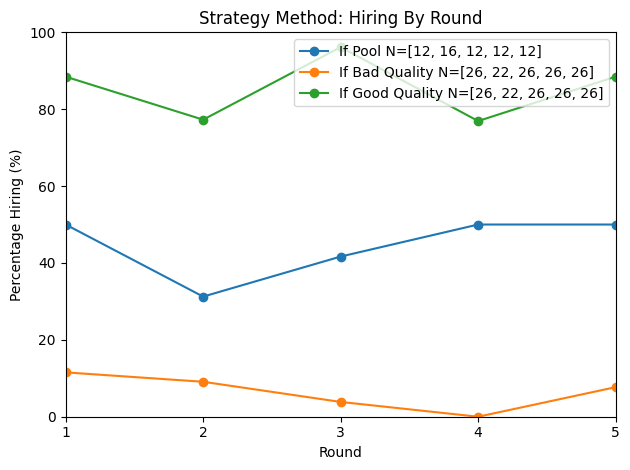

In [51]:
#  POOL
lengths = []
avgs_pool = []
for i in range(1,6):
    strategy_pool = strategy[strategy[f'EnvChoice_R{i}']==1]
    bonus_choice = strategy_pool[f'strategy_method.{i}.player.bonusChoicePool'].replace(3, 0)
    avg_pooling = bonus_choice.mean()*100
    avgs_pool.append(avg_pooling)
#     print(base_pool[f'informational_cost.{i}.player.bonusChoice'], bonus_choice)
    lengths.append(len(bonus_choice))
print(avgs_pool)
plt.plot(range(1,6), avgs_pool, label=f'If Pool N={lengths}', marker="o")

#  SEPARATE BAD
lengths = []
avgs_sep = []
for i in range(1,6):
    strategy_sep = strategy[strategy[f'EnvChoice_R{i}']==0]
    bonus_choice = strategy_sep[f'strategy_method.{i}.player.bonusChoiceSepBad'].replace(3, 0)
    avg_separating = bonus_choice.mean()*100
    avgs_sep.append(avg_separating)
    lengths.append(len(bonus_choice))
print(avgs_sep)
plt.plot(range(1,6), avgs_sep, label=f'If Bad Quality N={lengths}', marker="o")

#  SEPARATE GOOD
lengths = []
avgs_sep = []
for i in range(1,6):
    strategy_sep = strategy[strategy[f'EnvChoice_R{i}']==0]
    bonus_choice = strategy_sep[f'strategy_method.{i}.player.bonusChoiceSepGood'].replace(3, 0)
    avg_separating = bonus_choice.mean()*100
    avgs_sep.append(avg_separating)
    lengths.append(len(bonus_choice))
print(avgs_sep)
plt.plot(range(1,6), avgs_sep, label=f'If Good Quality N={lengths}', marker="o")

plt.xlabel("Round")
plt.ylabel("Percentage Hiring (%)")
plt.xlim(1, 5)
plt.xticks(np.arange(1,6), range(1,6))  # Set text labels.
plt.ylim(0, 100)
plt.axvline(x=5.5, linewidth=2, color = 'k')
plt.legend()
plt.title('Strategy Method: Hiring By Round')
plt.tight_layout()
plt.savefig(outputpath + 'strategy_bonus_choice_by_round_matters.png',dpi=1000)
plt.show()

##### Now, check what those who pooled said they would have done if separating

[25.0, 12.5, 16.666666666666664, 50.0, 33.33333333333333]
[75.0, 43.75, 50.0, 58.333333333333336, 83.33333333333334]


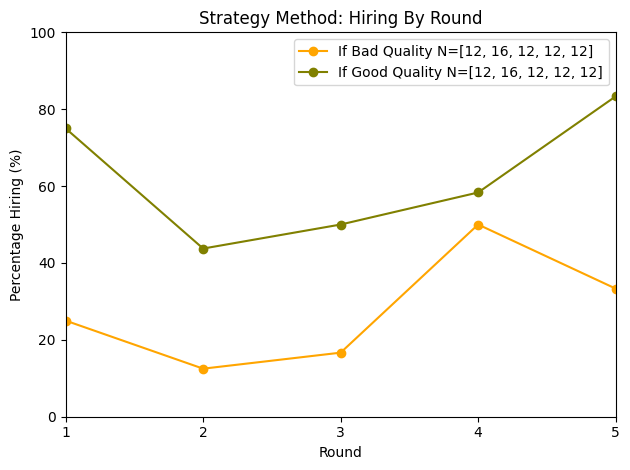

In [52]:
#  SEPARATE BAD
lengths = []
avgs_sep = []
for i in range(1,6):
    strategy_sep = strategy[strategy[f'EnvChoice_R{i}']==1]
    bonus_choice = strategy_sep[f'strategy_method.{i}.player.bonusChoiceSepBad'].replace(3, 0)
    avg_separating = bonus_choice.mean()*100
    avgs_sep.append(avg_separating)
    lengths.append(len(bonus_choice))
print(avgs_sep)
plt.plot(range(1,6), avgs_sep, label=f'If Bad Quality N={lengths}', marker="o", color='orange')

#  SEPARATE GOOD
lengths = []
avgs_sep = []
for i in range(1,6):
    strategy_sep = strategy[strategy[f'EnvChoice_R{i}']==1]
    bonus_choice = strategy_sep[f'strategy_method.{i}.player.bonusChoiceSepGood'].replace(3, 0)
    avg_separating = bonus_choice.mean()*100
    avgs_sep.append(avg_separating)
    lengths.append(len(bonus_choice))
print(avgs_sep)
plt.plot(range(1,6), avgs_sep, label=f'If Good Quality N={lengths}', marker="o", color='olive')

plt.xlabel("Round")
plt.ylabel("Percentage Hiring (%)")
plt.xlim(1, 5)
plt.xticks(np.arange(1,6), range(1,6))  # Set text labels.
plt.ylim(0, 100)
plt.axvline(x=5.5, linewidth=2, color = 'k')
plt.legend()
plt.title('Strategy Method: Hiring By Round')
plt.tight_layout()
plt.savefig(outputpath + 'strategy_bonus_choice_by_round_NOTmatters.png',dpi=1000)
plt.show()

### Baseline: Check if there is a group of people who always pool, or people going in and out

In [53]:
base['cum_mistakes_R1'] = np.nan
base['cum_mistakes_R2'] = np.nan
base['cum_mistakes_R3'] = np.nan
base['cum_mistakes_R4'] = np.nan
base['cum_mistakes_R5'] = np.nan
for ind in base.index:
    if base['risk_taker_R1'][ind] == 1 and base['Round1Param'][ind] != 5:
        base['cum_mistakes_R1'][ind] = base['EnvChoice_R1'][ind]
    else:
        base['cum_mistakes_R1'][ind] = 0
    if base['risk_taker_R2'][ind] == 1 and base['Round2Param'][ind] != 5:
        base['cum_mistakes_R2'][ind] = base['cum_mistakes_R1'][ind] + base['EnvChoice_R2'][ind]
    else:
        base['cum_mistakes_R2'][ind] = base['cum_mistakes_R1'][ind]
    if base['risk_taker_R3'][ind] == 1 and base['Round3Param'][ind] != 5:
        base['cum_mistakes_R3'][ind] = base['cum_mistakes_R2'][ind] + base['EnvChoice_R3'][ind]
    else:
        base['cum_mistakes_R3'][ind] = base['cum_mistakes_R2'][ind]
    if base['risk_taker_R4'][ind] == 1 and base['Round4Param'][ind] != 5:
        base['cum_mistakes_R4'][ind] = base['cum_mistakes_R3'][ind] + base['EnvChoice_R4'][ind]
    else:
        base['cum_mistakes_R4'][ind] = base['cum_mistakes_R3'][ind]
    if base['risk_taker_R5'][ind] == 1 and base['Round5Param'][ind] != 5:
        base['cum_mistakes_R5'][ind] = base['cum_mistakes_R4'][ind] + base['EnvChoice_R5'][ind]
    else:
        base['cum_mistakes_R5'][ind] = base['cum_mistakes_R4'][ind]        

print(base[['cum_mistakes_R1', 'cum_mistakes_R2','cum_mistakes_R3', 'cum_mistakes_R4','cum_mistakes_R5']])

     cum_mistakes_R1  cum_mistakes_R2  cum_mistakes_R3  cum_mistakes_R4  \
179              0.0              0.0              1.0              1.0   
181              1.0              2.0              2.0              2.0   
182              1.0              1.0              2.0              3.0   
232              1.0              1.0              1.0              1.0   
237              1.0              2.0              3.0              3.0   
239              1.0              2.0              2.0              2.0   
243              0.0              0.0              0.0              0.0   
247              1.0              2.0              2.0              2.0   
248              0.0              0.0              0.0              0.0   
252              1.0              2.0              2.0              3.0   
253              1.0              2.0              3.0              4.0   
255              0.0              0.0              1.0              2.0   
257              1.0     

In [54]:
for i in range(1,6):
    print(base[base['cum_mistakes_R5']==4][f'informational_cost.{i}.player.bonusChoice'])

182    1.0
252    1.0
253    1.0
279    1.0
305    3.0
Name: informational_cost.1.player.bonusChoice, dtype: float64
182    3.0
252    3.0
253    1.0
279    3.0
305    3.0
Name: informational_cost.2.player.bonusChoice, dtype: float64
182    1.0
252    3.0
253    1.0
279    3.0
305    3.0
Name: informational_cost.3.player.bonusChoice, dtype: float64
182    1.0
252    3.0
253    1.0
279    3.0
305    1.0
Name: informational_cost.4.player.bonusChoice, dtype: float64
182    3.0
252    3.0
253    1.0
279    3.0
305    3.0
Name: informational_cost.5.player.bonusChoice, dtype: float64


In [55]:
base_pool1 = base_all[base_all['EnvChoice1']==1]
base_sep_good1 = base_all[(base_all['EnvChoice1']==0) & (base_all['RoundCounts1CompType']==1)]
base_sep_bad1 = base_all[(base_all['EnvChoice1']==0) & (base_all['RoundCounts1CompType']==0)]
base_pool2 = base_all[base_all['EnvChoice2']==1]
base_sep_good2 = base_all[(base_all['EnvChoice2']==0) & (base_all['RoundCounts2CompType']==1)]
base_sep_bad2 = base_all[(base_all['EnvChoice2']==0) & (base_all['RoundCounts2CompType']==0)]
base_sep_bad2
#%%
# Those who pool in first part 2
fig, ax = plt.subplots()
y = [int(i) for i in base_pool1['informational_cost.5.player.bonusChoice']]
xLabels = ['','Computer','', 'Outside Option', '']
x = np.arange(max(y)+2)
ax.hist(y,x-0.5, width=1)
plt.ylabel('Frequency')
for i in range(max(y)+2):
    plt.text(i,y.count(i)-1,str(y.count(i))+ ' (' + str(round(y.count(i)*100/len(y))) +'%)', color='white')
plt.xticks(x, xLabels)
plt.title(f'Base - Part 2 (pool, first) Choice N={len(y)}')
plt.tight_layout()
# plt.savefig(outputpath + baseline['inference.1.player.bonusChoice'].name[19:] +'.png',dpi=1000)
plt.show()

# Those who pool in second part 2
fig, ax = plt.subplots()
y = [int(i) for i in base_pool2['informational_cost.10.player.bonusChoice']]
xLabels = ['','Computer','', 'Outside Option', '']
x = np.arange(max(y)+2)
ax.hist(y,x-0.5, width=1)
plt.ylabel('Frequency')
for i in range(max(y)+2):
    plt.text(i,y.count(i)-1,str(y.count(i))+ ' (' + str(round(y.count(i)*100/len(y))) +'%)', color='white')
plt.xticks(x, xLabels)
plt.title(f'Base - Part 2 (pool, second) Choice N={len(y)}')
plt.tight_layout()
# plt.savefig(outputpath + baseline['inference.1.player.bonusChoice'].name[19:] +'.png',dpi=1000)
plt.show()

# Those who separate and Good in first part 2
fig, ax = plt.subplots()
y = [int(i) for i in base_sep_good1['informational_cost.5.player.bonusChoice']]
xLabels = ['','Computer','', 'Outside Option', '']
x = np.arange(max(y)+2)
ax.hist(y,x-0.5, width=1)
plt.ylabel('Frequency')
for i in range(max(y)+2):
    plt.text(i,y.count(i)-1,str(y.count(i))+ ' (' + str(round(y.count(i)*100/len(y))) +'%)', color='white')
plt.xticks(x, xLabels)
plt.title(f'Base - Part 2 (separate, good, first) Choice N={len(y)}')
plt.tight_layout()
# plt.savefig(outputpath + baseline['inference.1.player.bonusChoice'].name[19:] +'.png',dpi=1000)
plt.show()

# Those who separate and Good in second part 2
fig, ax = plt.subplots()
y = [int(i) for i in base_sep_good2['informational_cost.10.player.bonusChoice']]
xLabels = ['','Computer','', 'Outside Option', '']
x = np.arange(max(y)+2)
ax.hist(y,x-0.5, width=1)
plt.ylabel('Frequency')
for i in range(max(y)+2):
    plt.text(i,y.count(i)-1,str(y.count(i))+ ' (' + str(round(y.count(i)*100/len(y))) +'%)', color='white')
plt.xticks(x, xLabels)
plt.title(f'Base - Part 2 (separate, good, second) Choice N={len(y)}')
plt.tight_layout()
# plt.savefig(outputpath + baseline['inference.1.player.bonusChoice'].name[19:] +'.png',dpi=1000)
plt.show()

# Those who separate and Bad in first part 2
fig, ax = plt.subplots()
y = [int(i) for i in base_sep_bad1['informational_cost.5.player.bonusChoice']]
xLabels = ['','Computer','', 'Outside Option', '']
x = np.arange(max(y)+2)
ax.hist(y,x-0.5, width=1)
plt.ylabel('Frequency')
for i in range(max(y)+2):
    plt.text(i,y.count(i)-1,str(y.count(i))+ ' (' + str(round(y.count(i)*100/len(y))) +'%)', color='white')
plt.xticks(x, xLabels)
plt.title(f'Base - Part 2 (separate, bad, first) Choice N={len(y)}')
plt.tight_layout()
# plt.savefig(outputpath + baseline['inference.1.player.bonusChoice'].name[19:] +'.png',dpi=1000)
plt.show()

# Those who separate and Bad in second part 2
fig, ax = plt.subplots()
y = [int(i) for i in base_sep_bad2['informational_cost.10.player.bonusChoice']]
xLabels = ['','Computer','', 'Outside Option', '']
x = np.arange(max(y)+2)
ax.hist(y,x-0.5, width=1)
plt.ylabel('Frequency')
for i in range(max(y)+2):
    plt.text(i,y.count(i)-1,str(y.count(i))+ ' (' + str(round(y.count(i)*100/len(y))) +'%)', color='white')
plt.xticks(x, xLabels)
plt.title(f'Base - Part 2 (separate, bad, second) Choice N={len(y)}')
plt.tight_layout()
# plt.savefig(outputpath + baseline['inference.1.player.bonusChoice'].name[19:] +'.png',dpi=1000)
plt.show()

NameError: name 'base_all' is not defined

### Salient part 2

In [ ]:
#%%
salient_all = data[data['participant.treatment']=='salient']
for ind in salient_all.index:
    salient_all['participant.chosen_decisions'][ind] = int(salient_all['participant.chosen_decisions'][ind][0])
salient_all = salient_all[(salient_all['participant.chosen_decisions']<6)]
#%%
myList = []
for ind in salient_all.index:
    myList.append(int(salient_all['participant.compType'][ind][int(salient_all['participant.chosen_decisions'][ind])-1]))
    # print(myList,  data['participant.compType'])
salient_all['RoundCounts1CompType'] = myList
#%%
myList = []
for ind in salient_all.index:
    r1 = int(salient_all['participant.chosen_decisions'][ind])
    myList.append(int(salient_all[f'informational_cost.{r1}.player.environment_choice'][ind]))
    # print(myList,  data['participant.compType'])
salient_all['EnvChoice1'] = myList
#%%
salient_pool = salient_all[salient_all['EnvChoice1']==1]
salient_sep_good = salient_all[(salient_all['EnvChoice1']==0) & (salient_all['RoundCounts1CompType']==1)]
salient_sep_bad = salient_all[(salient_all['EnvChoice1']==0) & (salient_all['RoundCounts1CompType']==0)]
#%%
# Those who pool in first part 2
fig, ax = plt.subplots()
y = [int(i) for i in salient_pool['informational_cost.10.player.bonusChoice']]
xLabels = ['','Computer','', 'Outside Option', '']
x = np.arange(max(y)+2)
ax.hist(y,x-0.5, width=1)
plt.ylabel('Frequency')
for i in range(max(y)+2):
    plt.text(i,y.count(i)-1,str(y.count(i))+ ' (' + str(round(y.count(i)*100/len(y))) +'%)', color='white')
plt.xticks(x, xLabels)
plt.title(f'Salient - Part 2 (pool) Choice N={len(y)}')
plt.tight_layout()
# plt.savefig(outputpath + baseline['inference.1.player.bonusChoice'].name[19:] +'.png',dpi=1000)
plt.show()

# Those who separate and Good in first part 2
fig, ax = plt.subplots()
y = [int(i) for i in salient_sep_good['informational_cost.10.player.bonusChoice']]
xLabels = ['','Computer','', 'Outside Option', '']
x = np.arange(max(y)+2)
ax.hist(y,x-0.5, width=1)
plt.ylabel('Frequency')
for i in range(max(y)+2):
    plt.text(i,y.count(i)-1,str(y.count(i))+ ' (' + str(round(y.count(i)*100/len(y))) +'%)', color='white')
plt.xticks(x, xLabels)
plt.title(f'Salient - Part 2 (separate, good) Choice N={len(y)}')
plt.tight_layout()
# plt.savefig(outputpath + baseline['inference.1.player.bonusChoice'].name[19:] +'.png',dpi=1000)
plt.show()

# Those who separate and Bad in first part 2
fig, ax = plt.subplots()
y = [int(i) for i in salient_sep_bad['informational_cost.10.player.bonusChoice']]
xLabels = ['','Computer','', 'Outside Option', '']
x = np.arange(max(y)+2)
ax.hist(y,x-0.5, width=1)
plt.ylabel('Frequency')
for i in range(max(y)+2):
    plt.text(i,y.count(i)-1,str(y.count(i))+ ' (' + str(round(y.count(i)*100/len(y))) +'%)', color='white')
plt.xticks(x, xLabels)
plt.title(f'Salient - Part 2 (separate, bad) Choice N={len(y)}')
plt.tight_layout()
# plt.savefig(outputpath + baseline['inference.1.player.bonusChoice'].name[19:] +'.png',dpi=1000)
plt.show()

### Deterministic part 2

In [ ]:
#%%
det_all = data[(data['participant.treatment'] == 'deterministic')]
for ind in det_all.index:
    det_all['participant.chosen_decisions'][ind] = int(det_all['participant.chosen_decisions'][ind][0])
det_all = det_all[(det_all['participant.chosen_decisions']<6)]

myList = []
for ind in det_all.index:
    r1 = int(det_all['participant.chosen_decisions'][ind])
    myList.append(int(det_all[f'informational_cost.{r1}.player.environment_choice'][ind]))
    # print(myList,  data['participant.compType'])
det_all['EnvChoice1'] = myList
det_pool = det_all[det_all['EnvChoice1'] == 1]
det_sep = det_all[det_all['EnvChoice1'] == 0]
#%%
# Those who pool in first part 2
fig, ax = plt.subplots()
y = [int(i) for i in det_pool['informational_cost.10.player.bonusChoice']]
xLabels = ['', 'Good', 'Bad', 'Outside Option', '']
x = np.arange(max(y)+2)
ax.hist(y,x-0.5, width=1)
plt.ylabel('Frequency')
for i in range(max(y)+2):
    plt.text(i,y.count(i)-1,str(y.count(i))+ ' (' + str(round(y.count(i)*100/len(y))) +'%)', color='white')
plt.xticks(x, xLabels)
plt.title(f'Deterministic - Part 2 (pool) Choice N={len(y)}')
plt.tight_layout()
# plt.savefig(outputpath + baseline['inference.1.player.bonusChoice'].name[19:] +'.png',dpi=1000)
plt.show()

# Those who separate in first part 2
fig, ax = plt.subplots()
y = [int(i) for i in det_sep['informational_cost.10.player.bonusChoice']]
xLabels = ['', 'Good', 'Bad', 'Outside Option', '']
x = np.arange(max(y)+2)
ax.hist(y,x-0.5, width=1)
plt.ylabel('Frequency')
for i in range(max(y)+2):
    plt.text(i,y.count(i)-1,str(y.count(i))+ ' (' + str(round(y.count(i)*100/len(y))) +'%)', color='white')
plt.xticks(x, xLabels)
plt.title(f'Deterministic - Part 2 (separate) Choice N={len(y)}')
plt.tight_layout()
# plt.savefig(outputpath + baseline['inference.1.player.bonusChoice'].name[19:] +'.png',dpi=1000)
plt.show()